In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
df = pd.read_csv("/kaggle/input/attention-cnn-dataset/patient_diagnosis.csv")
df.head()

,101,URTI
0,102,Healthy
1,103,Asthma
2,104,COPD
3,105,URTI
4,106,COPD


In [4]:
df['URTI'].unique()

array(['Healthy', 'Asthma', 'COPD', 'URTI', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [5]:
sr_no = {'101':'URTI'}
for i, j in zip(df['101'].unique(), df['URTI']):
    sr_no[str(i)] = j

In [6]:
sr_no.keys()

dict_keys(['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226'])

In [7]:
import os
sound_files = os.listdir('/kaggle/input/attention-cnn-dataset/Mel Spectrogram/Mel Spectrogram/Original')

In [8]:
req_file_names = []

for i in sound_files:
      req_file_names.append([i])

In [9]:
labels = []
for i in range(len(req_file_names)):
    req_file_names[i].append(sr_no[req_file_names[i][0][:3]])
    labels.append(sr_no[req_file_names[i][0][:3]])

In [10]:
labels *= 3

In [11]:
x = []

for i in req_file_names:
    img = cv2.imread('/kaggle/input/attention-cnn-dataset/Mel Spectrogram/Mel Spectrogram/Time Stretch/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

for i in req_file_names:
    img = cv2.imread('/kaggle/input/attention-cnn-dataset/Mel Spectrogram/Mel Spectrogram/Pitch Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)
    
for i in req_file_names:
    img = cv2.imread('/kaggle/input/attention-cnn-dataset/Mel Spectrogram/Mel Spectrogram/Audio Shift/'+i[0])
    img = cv2.resize(img, (350, 350))
    x.append(img)

# x = np.array(x)
# print(x.shape)

In [12]:
x_new = []
y = []

for i in range(len(labels)):
    if labels[i]=='Asthma' or labels[i]=='Bronchiolitis':
        continue
    x_new.append(x[i])
    y.append(labels[i])

In [13]:
x = np.array(x_new)
print(x.shape)

(2718, 350, 350, 3)


In [14]:
req_file_names *= 3

In [15]:
y = np.array(y)
y.shape

(2718,)

In [16]:
one_hot_y = np.array(pd.get_dummies(y))

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, one_hot_y, test_size=0.2, random_state=39, stratify=y)
print(x_train.shape, y_train.shape, x_test.shape)

(2174, 350, 350, 3) (2174, 6) (544, 350, 350, 3)


In [18]:
enb1_wo_top = keras.applications.efficientnet.EfficientNetB1(include_top=False, weights='imagenet', input_shape=(350,350,3))

27018416/27018416 [==============================] - 0s 0us/step


In [19]:
enb1_xtrain = enb1_wo_top.predict(x_train)
enb1_xtest = enb1_wo_top.predict(x_test)

17/17 [==============================] - 2s 98ms/step


In [20]:
input_enb1 = keras.layers.Input(shape=enb1_xtrain.shape[1:])

# enb1_layer = enb1_wo_top(input_enb1)

# random = np.random.random(enb1_layer.shape[1:])

attention = keras.layers.Attention()([input_enb1, input_enb1])
flatten = keras.layers.Flatten()(attention)

dense1 = keras.layers.Dense(128, activation='relu')(flatten)
do1 = keras.layers.Dropout(0.3)(dense1)
bn1 = keras.layers.BatchNormalization()(do1)
dense2 = keras.layers.Dense(64, activation='relu')(bn1)
output = keras.layers.Dense(6, activation='softmax')(dense2)

enb1_model = keras.Model(inputs=input_enb1, outputs=output)
enb1_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11, 11, 128  0           []                               
                                0)]                                                               
                                                                                                  
 attention (Attention)          (None, 11, 11, 1280  0           ['input_2[0][0]',                
                                )                                 'input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 154880)       0           ['attention[0][0]']              
                                                                                              

In [21]:
checkpoint_enb1 = keras.callbacks.ModelCheckpoint('/kaggle/working/ENB1_Model-{epoch:02d}.h5', save_best_only=True)

enb1_model.compile(optimizer=keras.optimizers.Adam(3e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history_enb1 = enb1_model.fit(enb1_xtrain, y_train, batch_size=32, epochs=250, validation_data=(enb1_xtest, y_test), callbacks=[checkpoint_enb1])

Epoch 1/250
68/68 [==============================] - 7s 55ms/step - loss: 2.1777 - accuracy: 0.1155 - val_loss: 1.4738 - val_accuracy: 0.5294
Epoch 2/250
68/68 [==============================] - 2s 36ms/step - loss: 1.6883 - accuracy: 0.3514 - val_loss: 1.3236 - val_accuracy: 0.6434
Epoch 3/250
68/68 [==============================] - 3s 41ms/step - loss: 1.4847 - accuracy: 0.4604 - val_loss: 0.9269 - val_accuracy: 0.8272
Epoch 4/250
68/68 [==============================] - 3s 50ms/step - loss: 1.3738 - accuracy: 0.5143 - val_loss: 0.8654 - val_accuracy: 0.8474
Epoch 5/250
68/68 [==============================] - 2s 24ms/step - loss: 1.2832 - accuracy: 0.5814 - val_loss: 0.8677 - val_accuracy: 0.8309
Epoch 6/250
68/68 [==============================] - 2s 35ms/step - loss: 1.2389 - accuracy: 0.6104 - val_loss: 0.8472 - val_accuracy: 0.8640
Epoch 7/250
68/68 [==============================] - 3s 42ms/step - loss: 1.1825 - accuracy: 0.6573 - val_loss: 0.7719 - val_accuracy: 0.8621
Epoch 

In [23]:
df = pd.DataFrame(history_enb1.history)
df.to_csv('/kaggle/working/ENB1_history.csv')

In [24]:
enb1_model = keras.models.load_model("/kaggle/working/ENB1_Model-234.h5")

In [25]:
y_pred = enb1_model.predict(enb1_xtest)

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred = np.array(pred)

real = []
for i in y_test:
    real.append(np.argmax(i))
real = np.array(real)
    
print(confusion_matrix(real, pred))
accuracy_score(real, pred), precision_score(real, pred, average='weighted'), recall_score(real, pred, average='weighted'), f1_score(real, pred, average='weighted')

17/17 [==============================] - 0s 13ms/step
[[ 10   0   0   0   0   0]
 [  0 476   0   0   0   0]
 [  0   0  20   0   0   1]
 [  0   0   0   1   0   0]
 [  0   0   0   0  22   0]
 [  0   0   1   0   0  13]]


(0.9963235294117647,
 0.9963235294117647,
 0.9963235294117647,
 0.9963235294117647)

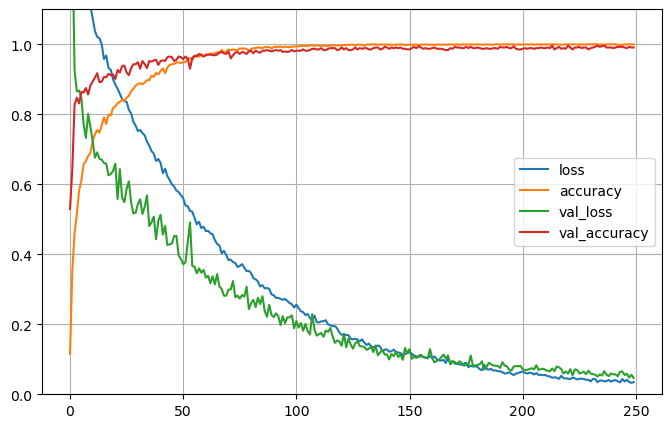

In [26]:
pd.DataFrame(history_enb1.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.savefig("/kaggle/working/ENB1_Attention_Graph.png")
plt.show()